In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ignite.metrics import Accuracy, Precision, Recall

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import albumentations as A

In [2]:
MNIST_1 = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

MNIST_2 = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [3]:
class Noisy(torch.utils.data.Dataset):
    
    def __init__(self, dataset, phase=None):

        if phase == 'train':
            start = 0
            end = int(len(dataset)*.75)
        elif phase == 'val':
            start = int(len(dataset)*.75)
            end = len(dataset)
        else:
            start = 0
            end = len(dataset)

        self.dataset = dataset.data[start:end] / 255

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        data = (self.dataset[idx] + torch.rand(28, 28) * .7 ).unsqueeze(0)
        target = self.dataset[idx].unsqueeze(0)
            
        return data, target

In [4]:
NOISY_train_dataset = Noisy(MNIST_1, 'train')
NOISY_val_dataset = Noisy(MNIST_1, 'val')

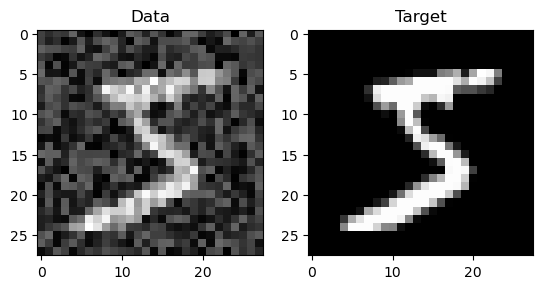

In [5]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(NOISY_train_dataset[0][0].squeeze(), cmap='gray')
axs[1].imshow(NOISY_train_dataset[0][1].squeeze(), cmap='gray')

axs[0].title.set_text('Data')
axs[1].title.set_text('Target')

plt.show()

In [6]:
denoiser = nn.Sequential(
    # encoder
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    # decoder
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 1, kernel_size=3, padding=1),
    nn.ReLU(),
)

In [7]:
%%capture

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

denoiser.to(device)

In [8]:
def train_model(model, batch_size, learning_rate, num_epochs, train_dataset, val_dataset,
               criterion, optimizer, scheduler, output_filename):
    '''Denoiser training function'''
    
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    scheduler = scheduler(optimizer)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    total_progress = tqdm(total=num_epochs, desc='Total progress')
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_progress = tqdm(total=len(train_loader), desc=f'Training epoch #{epoch}...', leave=False)
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_progress.update()
        epoch_progress.close()

        model.eval()
        val_progress = tqdm(total=len(val_loader), desc=f'Validating epoch #{epoch}...', leave=False)
        val_losses = []

        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_losses.append(loss.item())
            val_progress.update()
        val_progress.close()

        mean_val_loss = np.mean(val_losses)
        epoch_losses.append(mean_val_loss)

        if mean_val_loss == min(epoch_losses):
            torch.save(model, output_filename)            
        
        if scheduler:
            scheduler.step(mean_val_loss)

        print(f"Val loss #{epoch}: {np.mean(val_losses)}")

        total_progress.update()

    total_progress.close()

In [9]:
train_model(model=denoiser,
            batch_size=256,
            learning_rate=0.01,
            num_epochs=30,
            train_dataset=NOISY_train_dataset,
            val_dataset=NOISY_val_dataset,
            criterion=torch.nn.MSELoss,
            optimizer=optim.SGD,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau,
            output_filename='denoiser_least_loss.pt'
           )

Total progress:   0%|          | 0/30 [00:00<?, ?it/s]

Training epoch #0...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #0...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #0: 0.016419974771344055


Training epoch #1...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #1...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #1: 0.011203226617584794


Training epoch #2...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #2...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #2: 0.009353964447470034


Training epoch #3...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #3...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #3: 0.008369689823080928


Training epoch #4...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #4...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #4: 0.007807976992453559


Training epoch #5...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #5...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #5: 0.007330770178113954


Training epoch #6...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #6...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #6: 0.007010259089391615


Training epoch #7...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #7...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #7: 0.007050292392782235


Training epoch #8...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #8...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #8: 0.006647906905450559


Training epoch #9...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #9...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #9: 0.006334192237927247


Training epoch #10...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #10...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #10: 0.006134023929362075


Training epoch #11...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #11...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #11: 0.0059588798795337395


Training epoch #12...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #12...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #12: 0.00585602955513839


Training epoch #13...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #13...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #13: 0.005930604855135336


Training epoch #14...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #14...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #14: 0.005714406504027419


Training epoch #15...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #15...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #15: 0.005530587381730645


Training epoch #16...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #16...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #16: 0.006771391383924727


Training epoch #17...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #17...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #17: 0.005347429040693126


Training epoch #18...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #18...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #18: 0.005280816895981966


Training epoch #19...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #19...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #19: 0.005250004041245428


Training epoch #20...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #20...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #20: 0.00536075351223097


Training epoch #21...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #21...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #21: 0.005109420354020292


Training epoch #22...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #22...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #22: 0.005070079410038257


Training epoch #23...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #23...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #23: 0.005250393673461877


Training epoch #24...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #24...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #24: 0.004918272899053359


Training epoch #25...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #25...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #25: 0.004895033709452314


Training epoch #26...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #26...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #26: 0.0049612071301977515


Training epoch #27...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #27...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #27: 0.004775542718500404


Training epoch #28...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #28...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #28: 0.00473496995045472


Training epoch #29...:   0%|          | 0/176 [00:00<?, ?it/s]

Validating epoch #29...:   0%|          | 0/59 [00:00<?, ?it/s]

Val loss #29: 0.004877407103776932


**Inference**

In [10]:
def denoise(img, denoiser, device):
    '''Denoiser inference function'''
    
    
    denoiser.to(device).eval()
    data = img.reshape(-1, 1, 28, 28).to(device)
    denoised = denoiser(data).squeeze()
    
    return denoised

In [11]:
%%capture
best_denoiser = torch.load('denoiser_least_loss.pt')

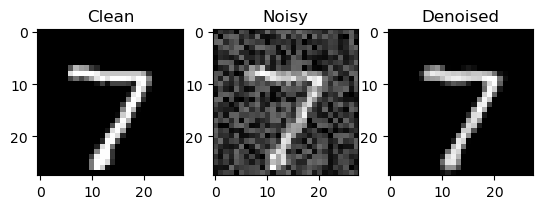

In [12]:
clean = MNIST_2[0][0].squeeze()
noisy = (MNIST_2[0][0] + torch.rand(28, 28) * .7).squeeze()
denoised = denoise(noisy, denoiser=best_denoiser, device=device).cpu().detach().numpy().squeeze()

fig, axs = plt.subplots(1, 3)

axs[0].imshow(clean, cmap='gray')
axs[1].imshow(noisy, cmap='gray')
axs[2].imshow(denoised, cmap='gray')

axs[0].title.set_text('Clean')
axs[1].title.set_text('Noisy')
axs[2].title.set_text('Denoised')

plt.show()

**Evaluation**

In [13]:
%%capture

# I trained a MNIST classifier previously
# so here i just used my old classifier model for the evaluation of the denoising autoencoder.
# You can find this MNIST convolutional classifier project on my GitHub:
# https://github.com/krupartea/MNIST-conv

classifier = torch.load('classifier_best_accuracy.pt')

In [14]:
test_loader = torch.utils.data.DataLoader(MNIST_2, batch_size=64, shuffle=False)

In [15]:
def evaluate_denoiser():
    accuracy = Accuracy()
    
    datasets = ['Clean', 'Noisy', 'Denoised']

    for dataset in datasets:
        accuracy.reset()
        
        for data, target in test_loader:
                if dataset == 'Noisy' or dataset == 'Denoised':
                    data += torch.rand(len(data), 1, 28, 28) *.7
                    if dataset == 'Denoised':
                        data = denoise(data, best_denoiser, device=device).unsqueeze(1)
                data = (data - data.mean()) / data.std()
                data = data.to(device)
                target = target.to(device)
                output = classifier(data)
                accuracy.update((output, target))

        print(f'{dataset} accuracy: {accuracy.compute()}')

In [16]:
evaluate_denoiser()

Clean accuracy: 0.9943
Noisy accuracy: 0.707
Denoised accuracy: 0.9907
